## Step 1: Import packages and data

In [258]:
%matplotlib notebook
# %matplotlib ipympl
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import itertools as it
from IPython.display import display
# from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from hmmlearn import hmm
from tslearn.metrics import dtw
import sklearn_crfsuite
from time import time


import warnings
warnings.filterwarnings('ignore')

desired_width=320
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',20)
np.set_printoptions(linewidth=desired_width)
np.set_printoptions(threshold=sys.maxsize)

In [79]:
Keypoints_1_7_normalized = pd.read_json('Keypoints_1_7_normalized_Ayosh&New.json', orient='records')

## Step 2: Feature Extraction

In [80]:
Keypoints_1_7_normalized.head()

,Depth,Frame No.,Gesture,Joint,Sub folder No.,X,Y
0,0.352941,1,1,1,1,0.508511,0.373518
1,0.360784,1,1,2,1,0.450394,0.376146
2,0.360784,1,1,3,1,0.435149,0.531236
3,0.325490,1,1,4,1,0.433452,0.686374
4,0.372549,1,1,5,1,0.565190,0.370778


In [81]:
pivot = Keypoints_1_7_normalized.pivot_table(index = ['Gesture', 'Sub folder No.', 'Frame No.'], columns = ['Joint'], values = ['X', 'Y', 'Depth'])
display(pivot.head())

Depth                                                                    X                      ...                                       Y                                                            
Joint                                    1         2         3        4         5         6         7         1         2         3  ...         5         6         7         1         2         3         4         5         6         7
Gesture Sub folder No. Frame No.                                                                                                     ...                                                                                                    
1       1              1          0.352941  0.360784  0.360784  0.32549  0.372549  0.333333  0.317647  0.508511  0.450394  0.435149  ...  0.565190  0.582080  0.594220  0.373518  0.376146  0.531236  0.686374  0.370778  0.520458  0.683699
                       2          0.352941  0.360784  0.372549  0.32549  0.372549  0.333333  0.317647  0.508513  0.450384  0.435136  ...  0.566653  0.582094  0.594226  0.373507  0.376154  0.531316  0.686310  0.370770  0.520386  0.683577
                       3          0.352941  0.372549  0.360784  0.32549  0.372549  0.345098  0.305882  0.508519  0.450400  0.436574  ...  0.566646  0.583520  0.594237  0.376095  0.376179  0.531209  0.686341  0.370756  0.525793  0.683741
                       4          0.352941  0.360784  0.360784  0.32549  0.372549  0.325490  0.305882  0.508527  0.450392  0.436577  ...  0.566669  0.583531  0.594243  0.373441  0.376104  0.531227  0.686369  0.368059  0.520424  0.683687
                       5          0.352941  0.360784  0.360784  0.32549  0.372549  0.325490  0.305882  0.508510  0.450403  0.436578  ...  0.565187  0.583510  0.594248  0.373445  0.376112  0.531222  0.686406  0.368070  0.523081  0.683663

[5 rows x 21 columns]

In [82]:
def joint_pair_distance(row, pairs):
    x = row['X']
    y = row['Y']
    z = row['Depth']
    
    result = np.empty(0)
    for pair in pairs:
        distance = np.sqrt((x[pair[0]] - x[pair[1]])**2 + (y[pair[0]] - y[pair[1]])**2 + (z[pair[0]] - z[pair[1]])**2)
        result = np.append(result, distance)
    return result

In [83]:
pairs = list(it.combinations(np.arange(1,8), 2))
joint_pair_distance_feature = pivot.apply(lambda x: joint_pair_distance(x, pairs), axis=1).rename('Feature')
joint_pair_distance_feature.to_frame().head()

Feature
Gesture Sub folder No. Frame No.                                                   
1       1              1          [0.05870225710256071, 0.1741215965966246, 0.32...
                       2          [0.05871490807598548, 0.17513485620624372, 0.3...
                       3          [0.06133731450468716, 0.1711657100421511, 0.32...
                       4          [0.05872185604879966, 0.1735934747943889, 0.32...
                       5          [0.05869436304790603, 0.1735777769394315, 0.32...

In [84]:
joint_pair_distance_feature_normalized = joint_pair_distance_feature.apply(lambda x: x/np.max(x)).rename('Feature_normalized')
joint_pair_distance_feature_normalized.to_frame().head()

Feature_normalized
Gesture Sub folder No. Frame No.                                                   
1       1              1          [0.1700475616866118, 0.5043920693970089, 0.935...
                       2          [0.16956391705309545, 0.5057753337947788, 0.93...
                       3          [0.1771182437472947, 0.4942598187944438, 0.926...
                       4          [0.16861705826034531, 0.49846552923491233, 0.9...
                       5          [0.1687997939067418, 0.4991943255309205, 0.928...

In [85]:
joint_pair_distance_feature_normalized2 = joint_pair_distance_feature_normalized.apply(lambda x: x/joint_pair_distance_feature_normalized.iloc[0]).rename('Feature_normalized2')
joint_pair_distance_feature_normalized2.to_frame().head()

Feature_normalized2
Gesture Sub folder No. Frame No.                                                   
1       1              1          [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
                       2          [0.9971558272949089, 1.0027424388322037, 0.997...
                       3          [1.041580614214944, 0.9799119549705094, 0.9900...
                       4          [0.9915876275315089, 0.9882501321458491, 0.991...
                       5          [0.9926622424485593, 0.9896950325323272, 0.993...

## Step 3: Prepare Training and Testing Dataset

In [86]:
gesture_number = len(Keypoints_1_7_normalized['Gesture'].unique())

In [87]:
dataset = joint_pair_distance_feature_normalized.reset_index().pivot_table(index=['Gesture', 'Sub folder No.'], values=['Feature_normalized'], aggfunc=lambda x: np.vstack(x).tolist()).iloc[:,0]
dataset.to_frame().head()

Feature_normalized
Gesture Sub folder No.                                                   
1       1               [[0.1700475616866118, 0.5043920693970089, 0.93...
        2               [[0.16412771913142, 0.5113993270366352, 0.9366...
        3               [[0.18159262784347113, 0.5552951589766314, 0.9...
        4               [[0.16063530937248446, 0.4916462813066789, 0.9...
        5               [[0.14790436627187947, 0.49390226165478524, 0....

### 80% - 20%

In [483]:
msk = np.concatenate([np.random.rand(len(dataset.loc[i])) < 0.8 for i in np.arange(1,gesture_number+1)])
train_data_8020 = dataset.iloc[msk]
test_data_8020 = dataset.iloc[~msk]
print('80%-20% Train dataset\'s recording number', len(train_data_8020))
print('80%-20% Test dataset\'s recording number', len(test_data_8020))

test_label_8020 = test_data_8020.reset_index(0).iloc[:,0].values
print('80%-20% Test label:', test_label_8020)

80%-20% Train dataset's recording number 113
80%-20% Test dataset's recording number 26
80%-20% Test label: [1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 5 5 6 6 7 7]


### Jack-Knife

In [394]:
train_data_jackknife = pd.concat([dataset[[dataset.index.values[i][0] == j for i in range(len(dataset))]].iloc[:-3] for j in range(1,gesture_number+1)])
test_data_jackknife = pd.concat([dataset[[dataset.index.values[i][0] == j for i in range(len(dataset))]].iloc[-3:] for j in range(1,gesture_number+1)])
print('Jack-Knife Train dataset\'s recording number', len(train_data_jackknife))
print('Jack-Knife Test dataset\'s recording number', len(test_data_jackknife))

test_label_jackknife = test_data_jackknife.reset_index(0).iloc[:,0].values
print('80%-20% Test label:', test_label_jackknife)

Jack-Knife Train dataset's recording number 118
Jack-Knife Test dataset's recording number 21
80%-20% Test label: [1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]


## Step 4: Gaussian HMM

### 80% - 20%

In [484]:
hmm_train_data_8020 = [np.vstack(train_data_8020.loc[i].values) for i in range(1, gesture_number+1)]
[print('80%%-20%% Gesture %d Train data shape: %s' % (i+1, hmm_train_data_8020[i].shape)) for i in range(gesture_number)]
print()
hmm_train_lengths_8020 = [train_data_8020.loc[i].apply(len).values for i in range(1, gesture_number+1)]
[print('80%%-20%% Gesture %d Train sequence lengths: %s' % (i+1, hmm_train_lengths_8020[i])) for i in range(gesture_number)]
print()

80%-20% Gesture 1 Train data shape: (4428, 21)
80%-20% Gesture 2 Train data shape: (2928, 21)
80%-20% Gesture 3 Train data shape: (3364, 21)
80%-20% Gesture 4 Train data shape: (3558, 21)
80%-20% Gesture 5 Train data shape: (4043, 21)
80%-20% Gesture 6 Train data shape: (1864, 21)
80%-20% Gesture 7 Train data shape: (1823, 21)

80%-20% Gesture 1 Train sequence lengths: [128 146 138  95  78 100  90 139 140 118 130 129 137 377 365 375 278 298 370 399 398]
80%-20% Gesture 2 Train sequence lengths: [ 84  81 215  66  76 104 101 112  88  93  74  73 356 403 250 221 263 268]
80%-20% Gesture 3 Train sequence lengths: [ 77 178  76  68 101 136 109  92  86  62 164 395 377 248 264 328 292 311]
80%-20% Gesture 4 Train sequence lengths: [200 155  87  80  87 109  96  83  89  83  79 117 128 289 295 283 246 242 262 272 276]
80%-20% Gesture 5 Train sequence lengths: [ 86 125 196  97  98 120 124 102 101 105 112 137 138 331 322 311 292 320 306 316 304]
80%-20% Gesture 6 Train sequence lengths: [307 257 295

#### Diag covariance

In [485]:
print('80%-20%, Diagonal covariance\n')

hmm_state = range(1,27,2)

accuracy = []
best_accuracy = 0

for state in hmm_state:
    hmm_model = []
    # Train a HMM model using time sequences of training, train one HMM model for each gesture
    for i in range(gesture_number):
        hmm_model.append(hmm.GaussianHMM(n_components=state, covariance_type='diag').fit(hmm_train_data_8020[i], lengths=hmm_train_lengths_8020[i]))

    # After training HMM models, use them to classify each time sequence of testing
    scores = np.empty((0,gesture_number))
    
    start_time = time()
    for sequence in test_data_8020.values:
        score = np.empty(gesture_number)
        for k in range(gesture_number):
            try:
                score[k] = hmm_model[k].score(sequence)
            except:
                score[k] = -99999
        scores = np.vstack((scores, score))
    test_predict = np.argmax(scores, axis=1) + 1
    end_time = time()
    run_time = (end_time - start_time) / len(test_label_8020)
    
    accuracy.append(np.sum(test_predict == test_label_8020) / len(test_label_8020))
    print('HMM state = %d,\tAccuracy = %.3f,\tRun time = %.3f\nLabel:\t\t%s\nPrediction:\t%s\n' % (state, accuracy[-1], run_time, test_label_8020, test_predict))
    
    # Save the best accuracy information for further analysis
    if accuracy[-1] > best_accuracy:
        best_accuracy = accuracy[-1]
        best_hmm_state = state
        best_test_predict = test_predict

80%-20%, Diagonal covariance

HMM state = 1,	Accuracy = 0.923,	Run time = 0.005
Label:		[1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 5 5 6 6 7 7]
Prediction:	[1 5 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 1 5 6 6 7 7]

HMM state = 3,	Accuracy = 0.923,	Run time = 0.006
Label:		[1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 5 5 6 6 7 7]
Prediction:	[1 5 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 7 5 5 5 5 6 6 7 7]

HMM state = 5,	Accuracy = 0.923,	Run time = 0.010
Label:		[1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 5 5 6 6 7 7]
Prediction:	[1 7 1 1 2 2 2 2 2 3 3 3 3 3 1 4 4 4 5 5 5 5 6 6 7 7]

HMM state = 7,	Accuracy = 0.923,	Run time = 0.009
Label:		[1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 5 5 6 6 7 7]
Prediction:	[1 7 1 1 2 2 2 2 2 3 3 3 3 3 1 4 4 4 5 5 5 5 6 6 7 7]

HMM state = 9,	Accuracy = 0.923,	Run time = 0.012
Label:		[1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 5 5 6 6 7 7]
Prediction:	[1 1 1 1 2 2 2 2 2 3 3 3 3 3 1 5 4 4 5 5 5 5 6 6 7 7]

HMM state = 11,	Accuracy = 0.885,	Run time = 0.015
Label:		[1 1 1 1 2 2 2 2

<IPython.core.display.Javascript object>


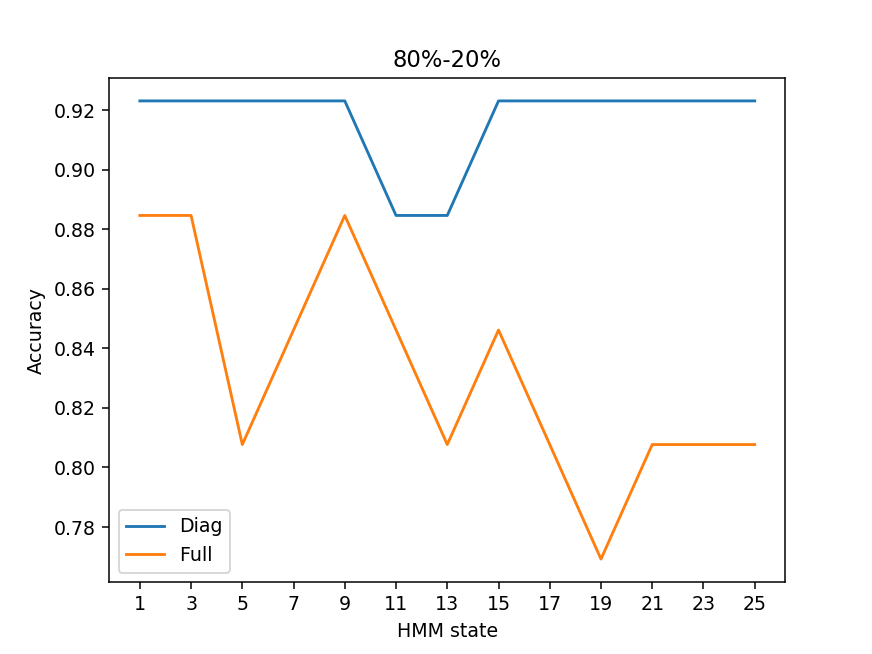

In [486]:
fig1 = plt.figure()
plt.title('80%-20%')
plt.plot(hmm_state, accuracy)
plt.xticks(hmm_state)
plt.xlabel('HMM state')
plt.ylabel('Accuracy')
plt.show()

In [487]:
print('80%-20%, Diagonal covariance\n')
print('Best accuracy occurs when:\nHMM state = %d,\t\tBest accuracy = %.3f\n' % (best_hmm_state, best_accuracy))
print('Classification Report:\n', classification_report(test_label_8020, best_test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label_8020, best_test_predict))

80%-20%, Diagonal covariance

Best accuracy occurs when:
HMM state = 1,		Best accuracy = 0.923

Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.75      0.75         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         4
           5       0.75      0.75      0.75         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2

    accuracy                           0.92        26
   macro avg       0.93      0.93      0.93        26
weighted avg       0.92      0.92      0.92        26

Confusion Matrix:
 [[3 0 0 0 1 0 0]
 [0 5 0 0 0 0 0]
 [0 0 5 0 0 0 0]
 [0 0 0 4 0 0 0]
 [1 0 0 0 3 0 0]
 [0 0 0 0 0 2 0]
 [0 0 0 0 0 0 2]]


#### Full covariance

In [488]:
print('80%-20%, Full covariance\n')

hmm_state = range(1,27,2)

accuracy = []
best_accuracy = 0

for state in hmm_state:
    hmm_model = []
    # Train a HMM model using time sequences of training, train one HMM model for each gesture
    for i in range(gesture_number):
        hmm_model.append(hmm.GaussianHMM(n_components=state, covariance_type='full').fit(hmm_train_data_8020[i], lengths=hmm_train_lengths_8020[i]))

    # After training HMM models, use them to classify each time sequence of testing
    scores = np.empty((0,gesture_number))
    
    start_time = time()
    for sequence in test_data_8020.values:
        score = np.empty(gesture_number)
        for k in range(gesture_number):
            try:
                score[k] = hmm_model[k].score(sequence)
            except:
                score[k] = -99999
        scores = np.vstack((scores, score))
    test_predict = np.argmax(scores, axis=1) + 1
    end_time = time()
    run_time = (end_time - start_time) / len(test_label_8020)
    
    accuracy.append(np.sum(test_predict == test_label_8020) / len(test_label_8020))
    print('HMM state = %d,\tAccuracy = %.3f,\tRun time = %.3f\nLabel:\t\t%s\nPrediction:\t%s\n' % (state, accuracy[-1], run_time, test_label_8020, test_predict))
    
    # Save the best accuracy information for further analysis
    if accuracy[-1] > best_accuracy:
        best_accuracy = accuracy[-1]
        best_hmm_state = state
        best_test_predict = test_predict

80%-20%, Full covariance

HMM state = 1,	Accuracy = 0.885,	Run time = 0.006
Label:		[1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 5 5 6 6 7 7]
Prediction:	[1 5 1 1 2 2 2 2 2 3 3 3 3 3 4 2 4 4 5 5 1 5 6 6 7 7]

HMM state = 3,	Accuracy = 0.885,	Run time = 0.010
Label:		[1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 5 5 6 6 7 7]
Prediction:	[1 1 1 1 2 2 2 2 2 3 3 3 3 3 2 2 4 5 5 5 5 5 6 6 7 7]

HMM state = 5,	Accuracy = 0.808,	Run time = 0.015
Label:		[1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 5 5 6 6 7 7]
Prediction:	[1 1 1 1 2 2 2 2 2 3 3 3 3 3 1 2 4 5 5 1 1 5 6 6 7 7]

HMM state = 7,	Accuracy = 0.846,	Run time = 0.018
Label:		[1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 5 5 6 6 7 7]
Prediction:	[1 1 1 1 2 2 2 2 2 3 3 3 3 3 2 2 4 4 5 1 1 5 6 6 7 7]

HMM state = 9,	Accuracy = 0.885,	Run time = 0.022
Label:		[1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 5 5 5 5 6 6 7 7]
Prediction:	[1 1 1 1 2 2 2 2 2 3 3 3 3 3 2 1 4 4 5 5 1 5 6 6 7 7]

HMM state = 11,	Accuracy = 0.846,	Run time = 0.028
Label:		[1 1 1 1 2 2 2 2 2 3

In [489]:
plt.plot(hmm_state, accuracy)
plt.xticks(hmm_state)
plt.xlabel('HMM state')
plt.ylabel('Accuracy')
plt.legend(['Diag', 'Full'])
plt.show()

In [490]:
print('80%-20%, Full covariance\n')
print('Best accuracy occurs when:\nHMM state = %d,\t\tBest accuracy = %.3f\n' % (best_hmm_state, best_accuracy))
print('Classification Report:\n', classification_report(test_label_8020, best_test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label_8020, best_test_predict))

80%-20%, Full covariance

Best accuracy occurs when:
HMM state = 1,		Best accuracy = 0.885

Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.75      0.75         4
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      0.75      0.86         4
           5       0.75      0.75      0.75         4
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2

    accuracy                           0.88        26
   macro avg       0.90      0.89      0.90        26
weighted avg       0.89      0.88      0.88        26

Confusion Matrix:
 [[3 0 0 0 1 0 0]
 [0 5 0 0 0 0 0]
 [0 0 5 0 0 0 0]
 [0 1 0 3 0 0 0]
 [1 0 0 0 3 0 0]
 [0 0 0 0 0 2 0]
 [0 0 0 0 0 0 2]]


### Jack-Knife

In [474]:
hmm_train_data_jackknife = [np.vstack(train_data_jackknife.loc[i].values) for i in range(1, gesture_number+1)]
[print('Jack-Knife Gesture %d Train data shape: %s' % (i+1, hmm_train_data_jackknife[i].shape)) for i in range(gesture_number)]
print()
hmm_train_lengths_jackknife = [train_data_jackknife.loc[i].apply(len).values for i in range(1, gesture_number+1)]
[print('Jack-Knife Gesture %d Train sequence lengths: %s' % (i+1, hmm_train_lengths_jackknife[i])) for i in range(gesture_number)]
print()

Jack-Knife Gesture 1 Train data shape: (3880, 21)
Jack-Knife Gesture 2 Train data shape: (3316, 21)
Jack-Knife Gesture 3 Train data shape: (3300, 21)
Jack-Knife Gesture 4 Train data shape: (3318, 21)
Jack-Knife Gesture 5 Train data shape: (3667, 21)
Jack-Knife Gesture 6 Train data shape: (1615, 21)
Jack-Knife Gesture 7 Train data shape: (1598, 21)

Jack-Knife Gesture 1 Train sequence lengths: [124 128 146 138  95  78 100  90 139 140 118 128 130 119 129 137 377 365 375 248 278 298]
Jack-Knife Gesture 2 Train sequence lengths: [ 84  81 211 215  66  76  90 104 101 112  88  93  74  73 362 356 403 256 250 221]
Jack-Knife Gesture 3 Train sequence lengths: [ 84  77 178 178  76  68 101 136 109  92  86  62  72 164 395 291 377 242 248 264]
Jack-Knife Gesture 4 Train sequence lengths: [102  85 200 155  87  87  80  87 109  96  83  89  83  79 117 128 289 295 283 246 242 296]
Jack-Knife Gesture 5 Train sequence lengths: [ 84  86 125 196  77  83  97  98 120 124 102 101 105 112 137 138 331 322 311 292

#### Diag covariance

In [475]:
print('Jack-Knife, Diagonal covariance\n')

hmm_state = range(1,27,2)

accuracy = []
best_accuracy = 0

for state in hmm_state:
    hmm_model = []
    # Train a HMM model using time sequences of training, train one HMM model for each gesture
    for i in range(gesture_number):
        hmm_model.append(hmm.GaussianHMM(n_components=state, covariance_type='diag').fit(hmm_train_data_jackknife[i], lengths=hmm_train_lengths_jackknife[i]))

    # After training HMM models, use them to classify each time sequence of testing
    scores = np.empty((0,gesture_number))
    
    start_time = time()
    for sequence in test_data_jackknife.values:
        score = np.empty(gesture_number)
        for k in range(gesture_number):
            try:
                score[k] = hmm_model[k].score(sequence)
            except:
                score[k] = -99999
        scores = np.vstack((scores, score))
    test_predict = np.argmax(scores, axis=1) + 1
    end_time = time()
    run_time = (end_time - start_time) / len(test_label_jackknife)
    
    accuracy.append(np.sum(test_predict == test_label_jackknife) / len(test_label_jackknife))
    print('HMM state = %d,\tAccuracy = %.3f,\tRun time = %.3f\nLabel:\t\t%s\nPrediction:\t%s\n' % (state, accuracy[-1], run_time, test_label_jackknife, test_predict))
    
    # Save the best accuracy information for further analysis
    if accuracy[-1] > best_accuracy:
        best_accuracy = accuracy[-1]
        best_hmm_state = state
        best_test_predict = test_predict

Jack-Knife, Diagonal covariance

HMM state = 1,	Accuracy = 0.952,	Run time = 0.009
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]
Prediction:	[1 2 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]

HMM state = 3,	Accuracy = 0.857,	Run time = 0.008
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 7 7 7 7 7 7]

HMM state = 5,	Accuracy = 1.000,	Run time = 0.009
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]

HMM state = 7,	Accuracy = 1.000,	Run time = 0.013
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]

HMM state = 9,	Accuracy = 0.952,	Run time = 0.016
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 2 5 5 5 6 6 6 7 7 7]

HMM state = 11,	Accuracy = 0.905,	Run time = 0.021
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]
Prediction:	[1 1 1 2 2 2 3 3 3 2 4 1 5 5 5 6 6 6 7 7 7]

HMM state = 

<IPython.core.display.Javascript object>


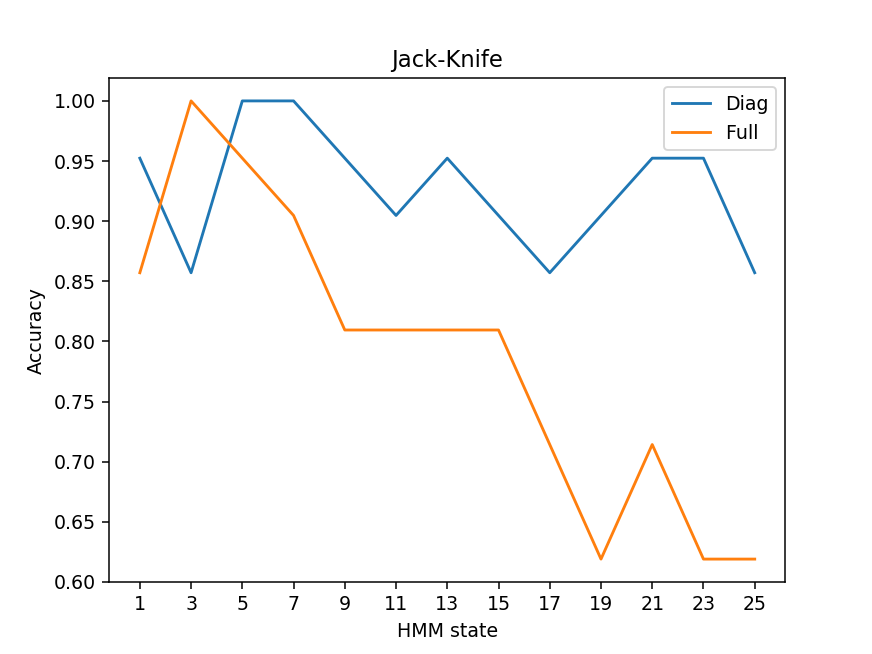

In [477]:
fig2 = plt.figure()
plt.title('Jack-Knife')
plt.plot(hmm_state, accuracy)
plt.xticks(hmm_state)
plt.xlabel('HMM state')
plt.ylabel('Accuracy')
plt.legend('Diag')
plt.show()

In [478]:
print('Jack-Knife, Diagonal covariance\n')
print('Best accuracy occurs when:\nHMM state = %d,\t\tBest accuracy = %.3f\n' % (best_hmm_state, best_accuracy))
print('Classification Report:\n', classification_report(test_label_jackknife, best_test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label_jackknife, best_test_predict))

Jack-Knife, Diagonal covariance

Best accuracy occurs when:
HMM state = 5,		Best accuracy = 1.000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Confusion Matrix:
 [[3 0 0 0 0 0 0]
 [0 3 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


#### Full covariance

In [479]:
print('Jack-Knife, Full covariance\n')

hmm_state = range(1,27,2)

accuracy = []
best_accuracy = 0

for state in hmm_state:
    hmm_model = []
    # Train a HMM model using time sequences of training, train one HMM model for each gesture
    for i in range(gesture_number):
        hmm_model.append(hmm.GaussianHMM(n_components=state, covariance_type='full').fit(hmm_train_data_jackknife[i], lengths=hmm_train_lengths_jackknife[i]))

    # After training HMM models, use them to classify each time sequence of testing
    scores = np.empty((0,gesture_number))
    
    start_time = time()
    for sequence in test_data_jackknife.values:
        score = np.empty(gesture_number)
        for k in range(gesture_number):
            try:
                score[k] = hmm_model[k].score(sequence)
            except:
                score[k] = -99999
        scores = np.vstack((scores, score))
    test_predict = np.argmax(scores, axis=1) + 1
    end_time = time()
    run_time = (end_time - start_time) / len(test_label_jackknife)
    
    accuracy.append(np.sum(test_predict == test_label_jackknife) / len(test_label_jackknife))
    print('HMM state = %d,\tAccuracy = %.3f,\tRun time = %.3f\nLabel:\t\t%s\nPrediction:\t%s\n' % (state, accuracy[-1], run_time, test_label_jackknife, test_predict))
    
    # Save the best accuracy information for further analysis
    if accuracy[-1] > best_accuracy:
        best_accuracy = accuracy[-1]
        best_hmm_state = state
        best_test_predict = test_predict

Jack-Knife, Full covariance

HMM state = 1,	Accuracy = 0.857,	Run time = 0.009
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 7 7 7 7 7 7]

HMM state = 3,	Accuracy = 1.000,	Run time = 0.012
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]

HMM state = 5,	Accuracy = 0.952,	Run time = 0.016
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 7 6 6 7 7 7]

HMM state = 7,	Accuracy = 0.905,	Run time = 0.023
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]
Prediction:	[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 7 6 7 7 7 7]

HMM state = 9,	Accuracy = 0.810,	Run time = 0.028
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]
Prediction:	[1 1 1 2 2 2 3 3 3 2 4 4 5 5 5 2 2 2 7 7 7]

HMM state = 11,	Accuracy = 0.810,	Run time = 0.042
Label:		[1 1 1 2 2 2 3 3 3 4 4 4 5 5 5 6 6 6 7 7 7]
Prediction:	[1 1 1 2 2 2 3 3 3 2 4 4 5 5 5 2 2 2 7 7 7]

HMM state = 13,	

In [480]:
plt.plot(hmm_state, accuracy)
plt.xticks(hmm_state)
plt.xlabel('HMM state')
plt.ylabel('Accuracy')
plt.legend(['Diag', 'Full'])
plt.show()

In [481]:
print('Jack-Knife, Full covariance\n')
print('Best accuracy occurs when:\nHMM state = %d,\t\tBest accuracy = %.3f\n' % (best_hmm_state, best_accuracy))
print('Classification Report:\n', classification_report(test_label_jackknife, best_test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label_jackknife, best_test_predict))

Jack-Knife, Full covariance

Best accuracy occurs when:
HMM state = 3,		Best accuracy = 1.000

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Confusion Matrix:
 [[3 0 0 0 0 0 0]
 [0 3 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


## Step 5: CRF

In [491]:
def crf_features(record):
    result = []
    for frame_feature in record:
        result.append(dict(zip(np.arange(1,22).astype('str'), frame_feature)))
    return result

### 80% - 20%

In [492]:
crf_train_data_8020 = train_data_8020.apply(crf_features)
crf_test_data_8020 = test_data_8020.apply(crf_features)

In [493]:
train_label_8020 = train_data_8020.reset_index(0).iloc[:,0].values
crf_train_label_8020 = [np.repeat(train_label_8020[i], len(train_data_8020.iloc[i])).astype('str').tolist() for i in range(len(train_label_8020))]

test_label_8020 = test_data_8020.reset_index(0).iloc[:,0].values
crf_test_label_8020 = [np.repeat(test_label_8020[i], len(test_data_8020.iloc[i])).astype('str').tolist() for i in range(len(test_label_8020))]

In [494]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
#     c1=0.1,
#     c2=0.1,
#     max_iterations=100,
#     all_possible_transitions=True
)
crf.fit(crf_train_data_8020, crf_train_label_8020)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=None,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [495]:
start_time = time()
crf_test_predict = crf.predict(crf_test_data_8020)
# labels = np.arange(1,8).astype('str').tolist()
# accuracy = metrics.flat_f1_score(crf_test_label, crf_test_predict,
#                       average='weighted', labels=labels)
test_predict = [int(max(set(x), key=x.count)) for x in crf_test_predict]
end_time = time()
run_time = (end_time - start_time) / len(test_label_8020)

accuracy = np.sum(test_predict == test_label_8020) / len(test_label_8020)

In [497]:
print('80%-20%\n')
print('Best accuracy = %.3f\tRun time = %.3f\n' % (accuracy, run_time))
print('Classification Report:\n', classification_report(test_label_8020, test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label_8020, test_predict))

80%-20%

Best accuracy = 0.923	Run time = 0.005

Classification Report:
               precision    recall  f1-score   support

           1       1.00      0.75      0.86         4
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      0.75      0.86         4
           5       0.80      1.00      0.89         4
           6       0.67      1.00      0.80         2
           7       1.00      1.00      1.00         2

    accuracy                           0.92        26
   macro avg       0.92      0.93      0.91        26
weighted avg       0.94      0.92      0.92        26

Confusion Matrix:
 [[3 0 0 0 1 0 0]
 [0 5 0 0 0 0 0]
 [0 0 5 0 0 0 0]
 [0 0 0 3 0 1 0]
 [0 0 0 0 4 0 0]
 [0 0 0 0 0 2 0]
 [0 0 0 0 0 0 2]]


### Jack-Knife

In [498]:
crf_train_data_jackknife = train_data_jackknife.apply(crf_features)
crf_test_data_jackknife = test_data_jackknife.apply(crf_features)

In [499]:
train_label_jackknife = train_data_jackknife.reset_index(0).iloc[:,0].values
crf_train_label_jackknife = [np.repeat(train_label_jackknife[i], len(train_data_jackknife.iloc[i])).astype('str').tolist() for i in range(len(train_label_jackknife))]

test_label_jackknife = test_data_jackknife.reset_index(0).iloc[:,0].values
crf_test_label_jackknife = [np.repeat(test_label_jackknife[i], len(test_data_jackknife.iloc[i])).astype('str').tolist() for i in range(len(test_label_jackknife))]

In [500]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
#     c1=0.1,
#     c2=0.1,
#     max_iterations=100,
#     all_possible_transitions=True
)
crf.fit(crf_train_data_jackknife, crf_train_label_jackknife)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=None,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=None,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [501]:
start_time = time()
crf_test_predict = crf.predict(crf_test_data_jackknife)
# labels = np.arange(1,8).astype('str').tolist()
# accuracy = metrics.flat_f1_score(crf_test_label, crf_test_predict,
#                       average='weighted', labels=labels)
test_predict = [int(max(set(x), key=x.count)) for x in crf_test_predict]
end_time = time()
run_time = (end_time - start_time) / len(test_label_jackknife)

accuracy = np.sum(test_predict == test_label_jackknife) / len(test_label_jackknife)

In [502]:
print('Jack-Knife\n')
print('Best accuracy = %.3f\tRun time = %.3f\n' % (accuracy, run_time))
print('Classification Report:\n', classification_report(test_label_jackknife, test_predict))
print('Confusion Matrix:\n', confusion_matrix(test_label_jackknife, test_predict))

Jack-Knife

Best accuracy = 0.810	Run time = 0.005

Classification Report:
               precision    recall  f1-score   support

           1       0.75      1.00      0.86         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      0.67      0.80         3
           6       0.00      0.00      0.00         3
           7       0.50      1.00      0.67         3

    accuracy                           0.81        21
   macro avg       0.75      0.81      0.76        21
weighted avg       0.75      0.81      0.76        21

Confusion Matrix:
 [[3 0 0 0 0 0 0]
 [0 3 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [1 0 0 0 2 0 0]
 [0 0 0 0 0 0 3]
 [0 0 0 0 0 0 3]]


## Step 6: DTW

In [275]:
dtw_train_data = dataset.loc[:,1]
dtw_test_data = dataset.loc[:,2:]
display(dtw_train_data)
display(dtw_test_data.head())

Gesture
1    [[0.1700475616866118, 0.5043920693970089, 0.93...
2    [[0.16157601308704053, 0.4985410363975585, 0.9...
3    [[0.16861077429251864, 0.493051849842906, 0.93...
4    [[0.16327308694487386, 0.49238465397934195, 0....
5    [[0.16545132560953207, 0.5273332878074187, 0.9...
6    [[0.17496708523894414, 0.537543819372994, 0.93...
7    [[0.1820139462488372, 0.5585558769599276, 0.95...
Name: Feature_normalized, dtype: object

Gesture  Sub folder No.
1        2                 [[0.16412771913142, 0.5113993270366352, 0.9366...
         3                 [[0.18159262784347113, 0.5552951589766314, 0.9...
         4                 [[0.16063530937248446, 0.4916462813066789, 0.9...
         5                 [[0.14790436627187947, 0.49390226165478524, 0....
         6                 [[0.14841233469121332, 0.49804549301225653, 0....
Name: Feature_normalized, dtype: object

In [276]:
dtw_test_label = dtw_test_data.reset_index().iloc[:,0].values

In [285]:
dtw_test_pred = np.empty(len(test_label_dtw))
start_time = time()
for i in range(len(dtw_test_label)):
    dist = np.empty(gesture_number)
    for j in range(gesture_number):
        dist[j] = dtw(dtw_train_data.iloc[j], dtw_test_data.iloc[i])
    dtw_test_pred[i] = np.argmin(dist) + 1
end_time = time()

run_time = (end_time - start_time) / len(dtw_test_label)
accuracy = np.sum(dtw_test_pred == dtw_test_label) / len(dtw_test_label)

In [286]:
print('Best accuracy = %.3f\tRun time = %.3f\n' % (accuracy, run_time))
print('Classification Report:\n', classification_report(dtw_test_label, dtw_test_pred))
print('Confusion Matrix:\n', confusion_matrix(dtw_test_label, dtw_test_pred))

Best accuracy = 0.909	Run time = 0.011

Classification Report:
               precision    recall  f1-score   support

           1       0.86      0.75      0.80        24
           2       0.92      1.00      0.96        22
           3       1.00      1.00      1.00        22
           4       1.00      0.88      0.93        24
           5       0.75      0.88      0.81        24
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8

    accuracy                           0.91       132
   macro avg       0.93      0.93      0.93       132
weighted avg       0.91      0.91      0.91       132

Confusion Matrix:
 [[18  1  0  0  5  0  0]
 [ 0 22  0  0  0  0  0]
 [ 0  0 22  0  0  0  0]
 [ 0  1  0 21  2  0  0]
 [ 3  0  0  0 21  0  0]
 [ 0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  8]]
